In [350]:
#| fold: false
#| echo: false
import torch
import numpy as np

from deep_parity.model import MLPv1 as MLP, Perceptron
from deep_parity.boolean_cube import fourier_transform, get_subcube, generate_all_binary_arrays

from pathlib import Path

import torch
import polars as pl
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns


from plotnine import ggplot, qplot, aes, geom_point, geom_histogram, facet_wrap, labs



def get_activations(model, n):
    batch_size = 2 ** 14
    bits = torch.from_numpy(generate_all_binary_arrays(n)).to(torch.float32)
    activations = []
    for batch in bits.split(batch_size):
        acts = relu(model.linear(batch))
        activations.append(acts.detach().cpu())
    return torch.concatenate(activations)


def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n).astype(np.int32)
    #all_binary_data = np.sign(-1 * all_binary_data_zero_one + 0.5)
    all_parities = all_binary_data.sum(axis=1) % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1)),
        degree=pl.col('bits').arr.sum().cast(pl.Int32),
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    centered_tensor = tensor - tensor.mean(dim=0, keepdims=True)
    ft = fourier_transform(centered_tensor.T)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by(['variable']).agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    powers = {}
    for i in range(1, n):
        print(i)
        power_df = (
            data.filter(pl.col('degree') == i)
            .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
            .unpivot()
            .with_columns(pl.col('variable').str.to_integer())
            .group_by(['variable']).agg(pl.col('value').pow(2).sum())
            .join(total_power, on='variable', how='left')
            .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
        )
        powers[f'degree_{i}'] = power_df['pcnt_power'].to_numpy()
    return powers


# Introduction

These are preliminary results I have reverse engineering a one-hidden-layer ReLU net that has learned to compute the parity of elements of the boolean cube $\{-1, 1 \}^{n}$ for $n = 18$ and $19$.

Most of this is setting up and explaining an interesting phenomenon I found: almost 25% of the neurons in my `n=18` model have zero bias and weights with equal magnitude but randomly flipped signs. This led me to realize that if `n` is even you can use "majority" neurons where the weight vector `w` is drawn uniformly from $\{-1, 1 \}^{18}$ then you can solve parity with only those majority neurons, though the precise formula depends on whether or not $n \equiv 0 \! \bmod{4}$ or $n \equiv 2 \bmod{4}$. For any $x \in \{-1, 1 \}^{n}$ and $w \sim \text{Unif}[\{-1, 1 \}^{n}]$. If $n \equiv 2 \bmod{4}$:

$$ \mathbb{E}[\chi(w) \cdot \max (\langle w, x \rangle, 0)] = C \chi(x)$$

for some constant $C$ (I need to calculate the normalization). If $n \equiv 0 \bmod{4}$ then you have to reverse the sign:

$$ \mathbb{E}[-\chi(w) \cdot \max (\langle w, x \rangle, 0)] = C \chi(x)$$


But **this doesn't work if `n` is odd**. Instead you need to use biased neurons:

$$ \mathbb{E}[\chi(w) \cdot \max (\langle w, x \rangle - \chi(w), 0)] = C \chi(x) + B$$

(that expression has a non-zero mean, but it also separates out the even and odd $x$ really well)

Note that as long as you keep track of the parity of your weight vector $w$ then you can use a collection of these neurons to approximate parity. The above expectations don't converge _quickly_ you need an exponential number of samples to get a clean separation, but I do think that the above represents part of what the models I have trained are doing.


# Set Up

I have trained a simple one-layer model to compute parity. It has $2,048$ neurons, which is many fewer than the $2^{18} = 262,144$ elements of $\{-1, 1 \}^{18}$.

In [7]:
#| echo : true
#| fold: false
checkpoint_dir = Path('checkpoints/1layer')
epoch = 10_000
model_run = torch.load(checkpoint_dir / f'{epoch}.pth', map_location='cpu', weights_only=True)
config = model_run['config']

model = Perceptron(config['n'],   config['model_dim'])
model.load_state_dict(model_run['model'])
model

Perceptron(
  (linear): Linear(in_features=18, out_features=2048, bias=True)
  (unembed): Linear(in_features=2048, out_features=2, bias=False)
)

First a little helper function to generate the boolean cube.

In [10]:
#| echo: true
#| fold: false
def generate_all_binary_arrays(n: int):
    """Create an array of all possible binary sequences on n bits.
    Parameters:
        n: integer, number of bits in the output
    Returns:
        x: numpy array with shape (2**n - 1, n) and every possible binary sequence.
    """
    # Create an array of all possible numbers for n bits
    numbers = np.arange(2**n, dtype=np.int32)
    # Use broadcasting with a single bitwise operation
    return -1. * np.sign(((numbers[:, np.newaxis] >> np.arange(n)[::-1]) & 1) - 0.5).astype(np.float32)

generate_all_binary_arrays(3)

array([[ 1.,  1.,  1.],
       [ 1.,  1., -1.],
       [ 1., -1.,  1.],
       [ 1., -1., -1.],
       [-1.,  1.,  1.],
       [-1.,  1., -1.],
       [-1., -1.,  1.],
       [-1., -1., -1.]], dtype=float32)

The model performs really well.

In [15]:
#| echo: true
def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels.unsqueeze(1))[:, 0]
    return (-1. * correct_log_probs).mean()

n = 18
boolean_cube = torch.from_numpy(generate_all_binary_arrays(n))
parities = boolean_cube.prod(dim=1)
labels = (parities == 1.).to(torch.int64)

logits = model(boolean_cube)
loss = loss_fn(logits, labels)
f'Total loss is: {loss.item()}'

'Total loss is: 2.9617095801682354e-08'

The question is _how_ is it doing this. There are lot of things to go over, but one thing that quickly stood out to me is that there are a _lot_ of neurons where the weight vector $w$, which is given by `model.linear.weight[i]` for some integer `i` between 0 and the number of neurons in the code, where every entry is the same up to the sign change. 

We can check this by plotting at the distribution of the variance of the absolute value of the weight vectors.



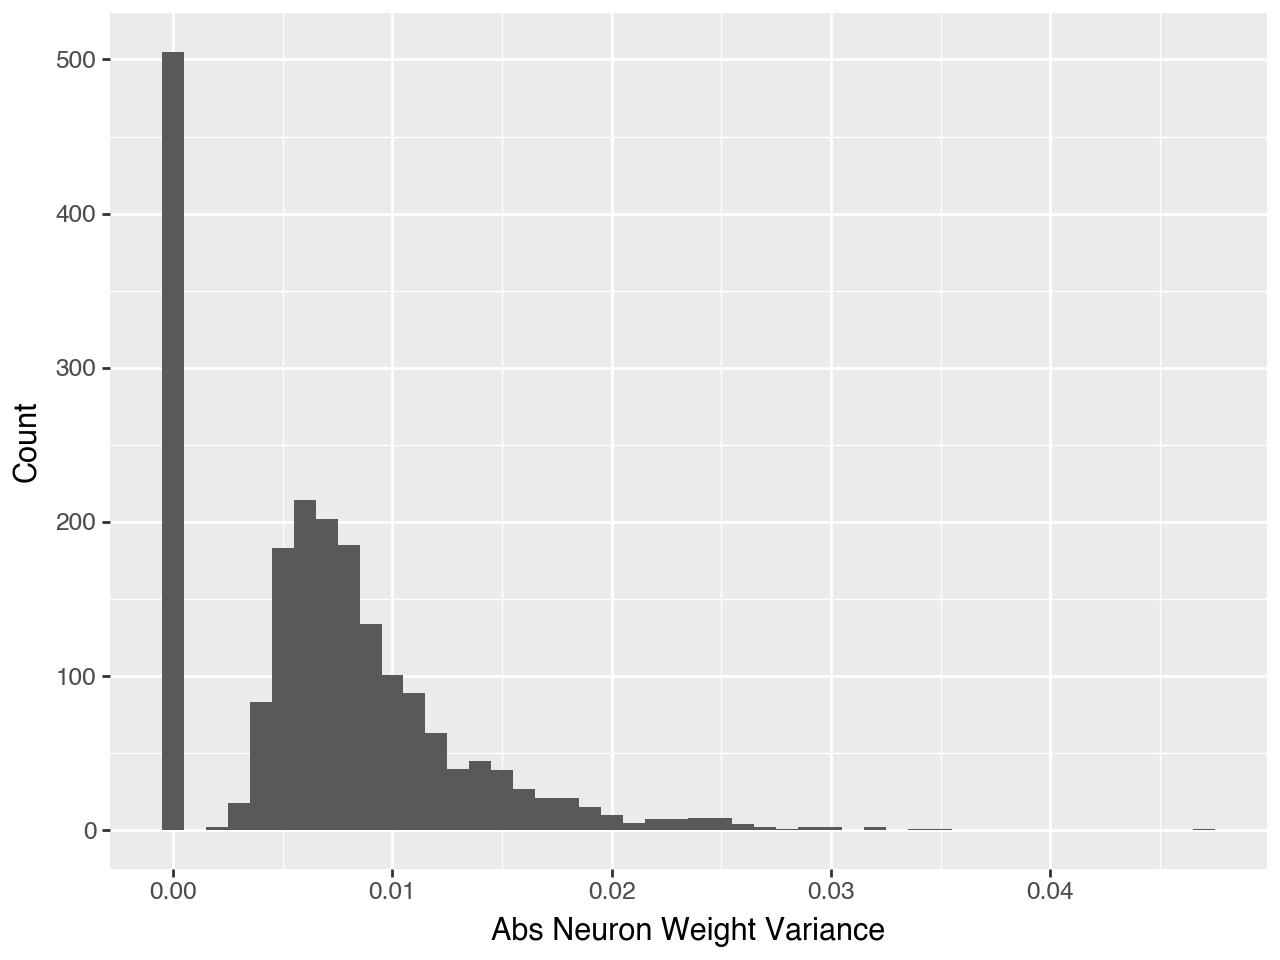

In [57]:
W = model.linear.weight.detach()
W /= W.pow(2).sum(dim=1, keepdims=True)
neuron_vars = np.var(W.abs().numpy(), axis=1)

neuron_var_df = pl.DataFrame({'neuron_var': neuron_vars}).with_row_index()

ggplot(neuron_var_df, aes(x='neuron_var')) + geom_histogram(binwidth=0.001) + labs(x='Abs Neuron Weight Variance', y = 'Count') 

500 neurons with basically zero variance represents almost 25% of the 2048 total neurons. Going forward I'm going to refer to them as "majority neurons" because they are equivalent to a straightforward all $1$s weight vector up to sign change.

They neurons are also (mostly) not using biases at all. A neuron gets classified as "majority" if `model.linear.weight[i].abs().var() < 0.0001`

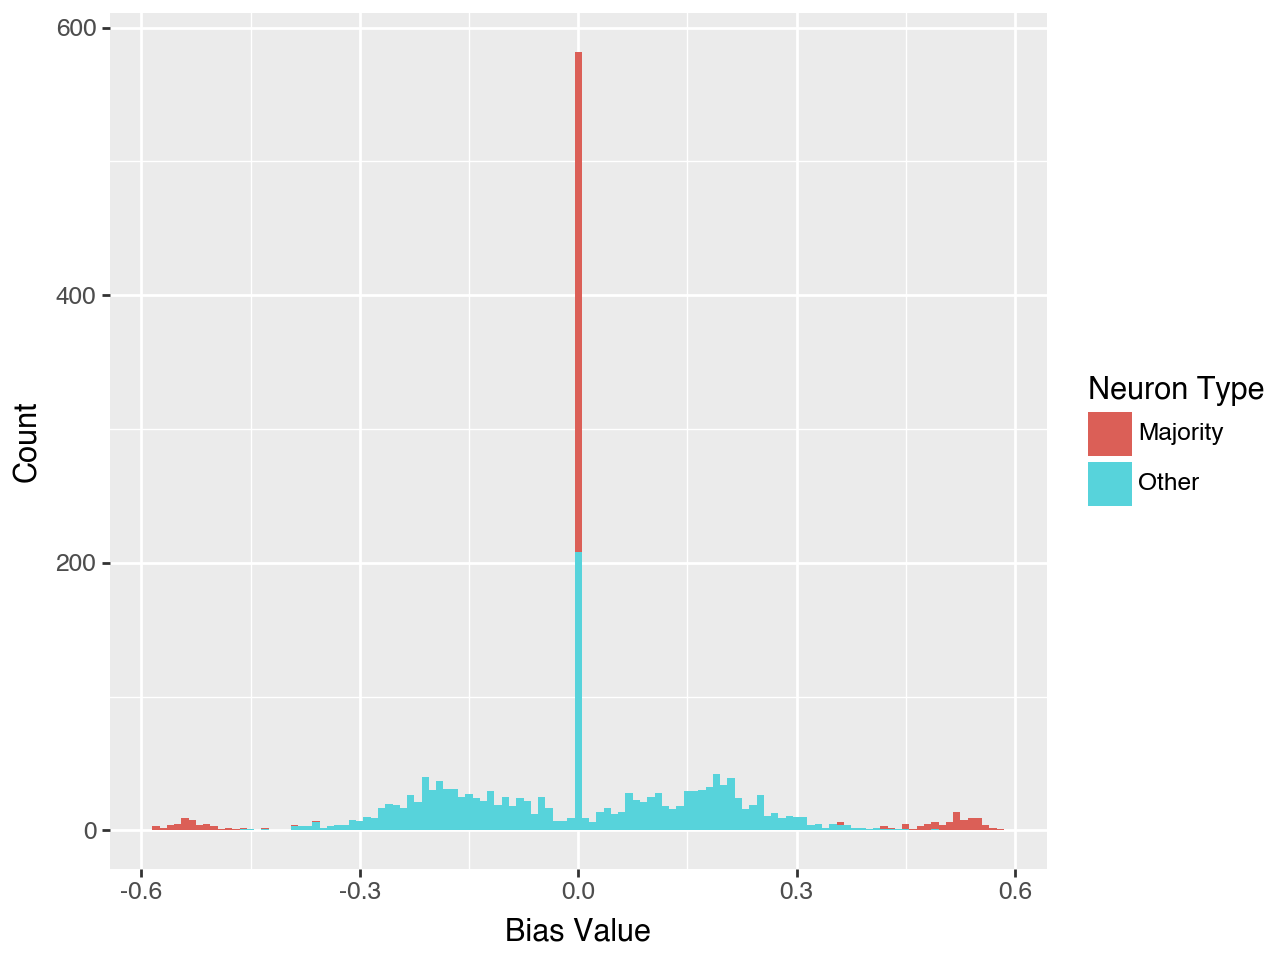

In [63]:
neuron_var_df = neuron_var_df.with_columns(
    bias_val = model.linear.bias.detach().numpy(),
    neuron_type = pl.when(pl.col('neuron_var').lt(0.0001)).then(pl.lit('Majority')).otherwise(pl.lit('Other'))
)

ggplot(neuron_var_df, aes(x='bias_val', fill = 'neuron_type')) + geom_histogram(binwidth = 0.01) + labs(x= 'Bias Value', y = 'Count', fill='Neuron Type')

On the other hand, when the majority neurons do have a bias, it is larger than the other neurons.

# Calculating Parity with Majority Neurons

Ok, if 25% of the neurons are doing this, they must be doing _something_, right? And it seems like it should be easy to check. Can we just add together a bunch of majority neurons (with randomly flipped signs) and have it average out to parity?

As it turns out, no. But if you keep track of the parity of your random weight vector $w$, you can. We can show with a simple simulation that:

$$ \mathbb{E}[\chi(w) \cdot \max (\langle w, x \rangle, 0)] = C \chi(x)$$


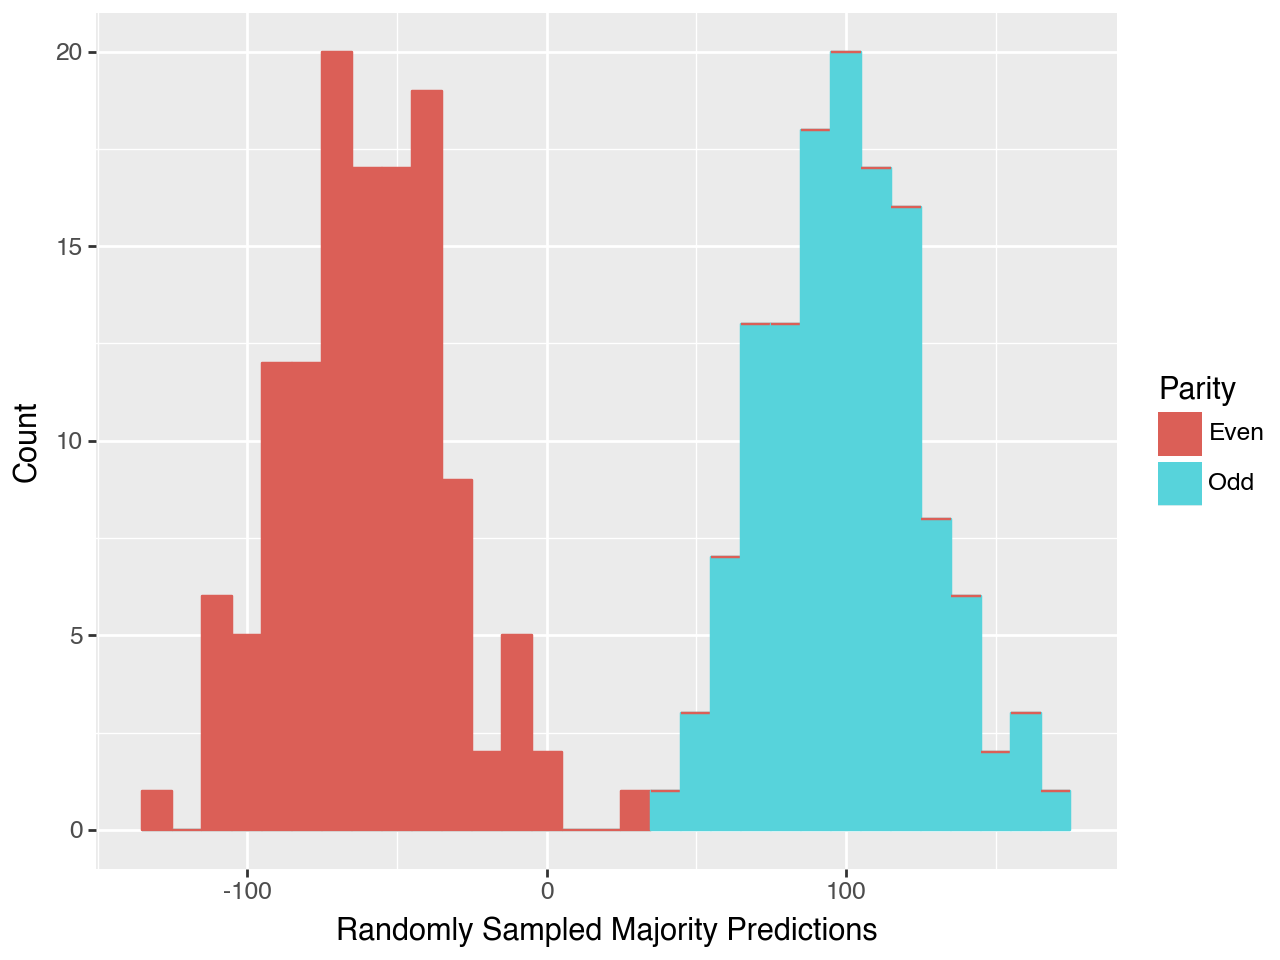

In [76]:
#| echo: true

from torch.nn.functional import relu

def rademacher(shape):
    """A helper to sample from the boolean cube for random weight vectors """
    return torch.sign(torch.bernoulli(torch.full(shape, 0.5)) - 0.5)

def parity(x):
    """ A helper for plotting our random model's predictions"""
    match x:
        case 1:
            return 'Even'
        case -1:
            return 'Odd'
        case _:
            raise ValueError('Must be 1 or -1')


n = 8
num_neurons = 2 ** (n + 1) # Twice as many as elements of small_cube
small_cube = torch.from_numpy(generate_all_binary_arrays(n))

W_rand = rademacher((num_neurons, n))
output_weights = W_rand.prod(dim=1) # set the "output" weights to the parity of W

rand_predictions = output_weights @ relu(W_rand @ small_cube.T)


data = {
    'preds': rand_predictions.detach().numpy(),
    'parity': [parity(int(x.item())) for x in small_cube.prod(dim=1)],
}


df = pl.DataFrame(data)

(
    ggplot(df, aes(x='preds', color='parity', fill='parity'))
    + geom_histogram(binwidth=10)
    + labs(x = 'Randomly Sampled Majority Predictions', y = 'Count', fill='Parity', color='Parity')
)

Not perfect and it takes a _ton_ of neurons, but pretty decent. Now to why this works at all.


# All the other Fourier terms except the final cancel out

When $n$ is even there is a non-zero Fourier component on the degree $n$ term, which also happens to be exactly the parity of the entire input -- aka exactly what we want the model to learn. When $n \equiv 0 \bmod 4$ this degree $n$ component is negative and when $n \equiv 2 \bmod 4$ it is positive.  

When $n$ is odd the degree $n$ Fourier component of a majority ReLU function is 0, because the parity of an odd number of inputs is an odd function, and the Fourier transform of ReLU neurons is zero on odd terms greater than $1$. This means that when trained on an odd number of inputs the neural net has to do something different, which we see.

## Checking this Computationally

We can check that there is a non-zero Fourier weight for a majority ReLU neuron computationally quite quickly. Though we first need a quick PyTorch Fast Walsh-Hadamard / Fourier transform.

In [285]:
#| echo: true

def fourier_transform(u, normalize=True):
    """Multiply H_n @ u where H_n is the Hadamard matrix of dimension n x n.
    n must be a power of 2.
    Works pretty well with torch.compile too.
    Parameters:
        u: Tensor of shape (..., n)
        normalize: if True, divide the result by 2^{m/2} where m = log_2(n).
    Returns:
        product: Tensor of shape (..., n)
    """
    _, n = u.shape
    m = int(np.log2(n))
    assert n == 1 << m, 'n must be a power of 2'
    x = u[..., np.newaxis]
    for _ in range(m)[::-1]:
        x = torch.cat((x[..., ::2, :] + x[..., 1::2, :], x[..., ::2, :] - x[..., 1::2, :]), dim=-1)
    return x.squeeze(-2) / 2**m  if normalize else x.squeeze(-2)


def majority_relu(n: int):
    """Calculate majority ReLU neuron for the entire boolean cube of size n
    """
    w = torch.ones(n, dtype=torch.float32)
    cube = torch.from_numpy(generate_all_binary_arrays(n))
    return relu(cube @ w)


# Get the even / odd pattern for 6 - 18
majority_fourier_transforms = {n: fourier_transform(majority_relu(n).unsqueeze(0), n) for n in range(6, 19)}
for k, v in majority_fourier_transforms.items():
    print(f'Degree {k} Fourier weight: {v.squeeze()[-1]}')

Degree 6 Fourier weight: 0.1875
Degree 7 Fourier weight: 0.0
Degree 8 Fourier weight: -0.15625
Degree 9 Fourier weight: 0.0
Degree 10 Fourier weight: 0.13671875
Degree 11 Fourier weight: 0.0
Degree 12 Fourier weight: -0.123046875
Degree 13 Fourier weight: 0.0
Degree 14 Fourier weight: 0.11279296875
Degree 15 Fourier weight: 0.0
Degree 16 Fourier weight: -0.104736328125
Degree 17 Fourier weight: 0.0
Degree 18 Fourier weight: 0.0981903076171875


So, basically, there's a little harmonic seed of the target function within majority a ReLU neuron (when $n$ is even). So when we sample a lot of random $w \sim \text{Unif}[\{-1, 1 \}^n]$ and aggregate them while keeping track of the parity of each random $w$, $\sum \chi(w_i)\cdot \langle w_i, x \rangle$, the degree $n$ parity terms will all sum and reinforce each other and all of the other Fourier terms cancel out.

The basic idea for them cancelling out: Consider a fixed subset of $S \subset [n]$. Then over the set of _all_ even $w \in \{-1, 1 \}^n$, half will have $\chi_S(w) = \chi(w)$ and the other half will disagree. Same is true for all the odd $w$. Thus in expectation every term _except_ the degree-$n$ parity term will end up cancelling out with enough $w$.

I would really like to calculate how quickly this all converges, but I have not done so.

# Models trained on Odd $n$ Do Something Different

The above strategy doesn't work when $n$ is odd, because parity becomes an odd function and there's no Fourier "seed" to amplify. Instead when the ReLU neuron has a bias there is a little signal, so they use those much more.

In [334]:
#| echo : true
#| fold: false
checkpoint_dir = Path('checkpoints/19')
epoch = 18_000
model_run = torch.load(checkpoint_dir / f'{epoch}.pth', map_location='cpu', weights_only=True)
config = model_run['config']

model = Perceptron(config['n'],   config['model_dim'])
model.load_state_dict(model_run['model'])
model

Perceptron(
  (linear): Linear(in_features=19, out_features=2048, bias=True)
  (unembed): Linear(in_features=2048, out_features=2, bias=False)
)

In [336]:
n = 19
boolean_cube = torch.from_numpy(generate_all_binary_arrays(n))
parities = boolean_cube.prod(dim=1)
# I had a bug in the code and ended up training on reversed labels. Whoops...
labels = (parities == -1.).to(torch.int64)

logits = model(boolean_cube)
loss = loss_fn(logits, labels)
f'Total loss is: {loss.item()}'

'Total loss is: 3.2356146741204555e-09'

This model has a similar preponderance of "majority" neurons.

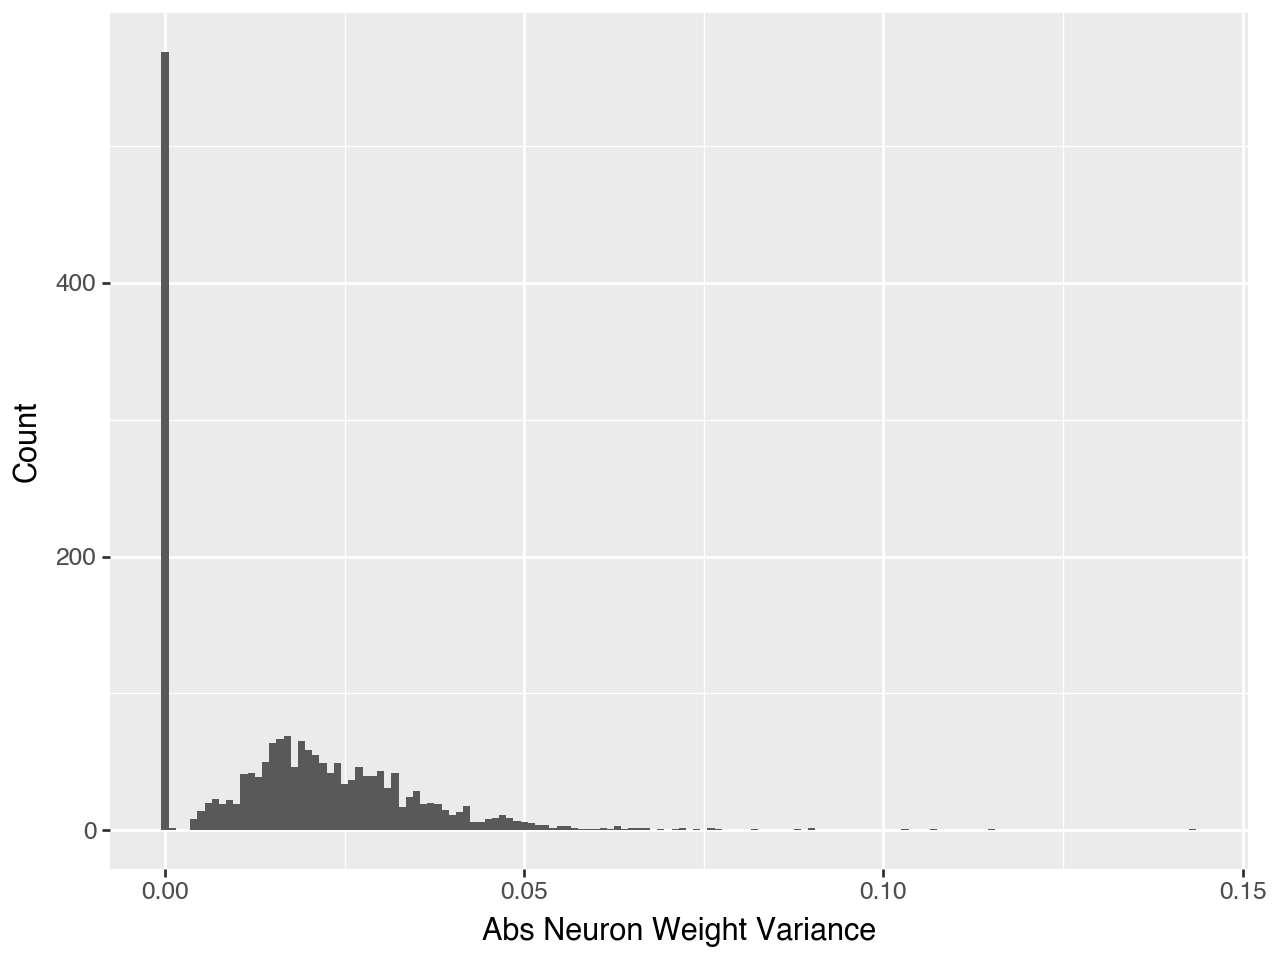

In [337]:
W = model.linear.weight.detach()
W /= W.pow(2).sum(dim=1, keepdims=True)
neuron_vars = np.var(W.abs().numpy(), axis=1)

neuron_var_df = pl.DataFrame({'neuron_var': neuron_vars}).with_row_index()

ggplot(neuron_var_df, aes(x='neuron_var')) + geom_histogram(binwidth=0.001) + labs(x='Abs Neuron Weight Variance', y = 'Count') 

But now there are not very many neurons with `0` bias, and no "majority" neurons with 0 bias.

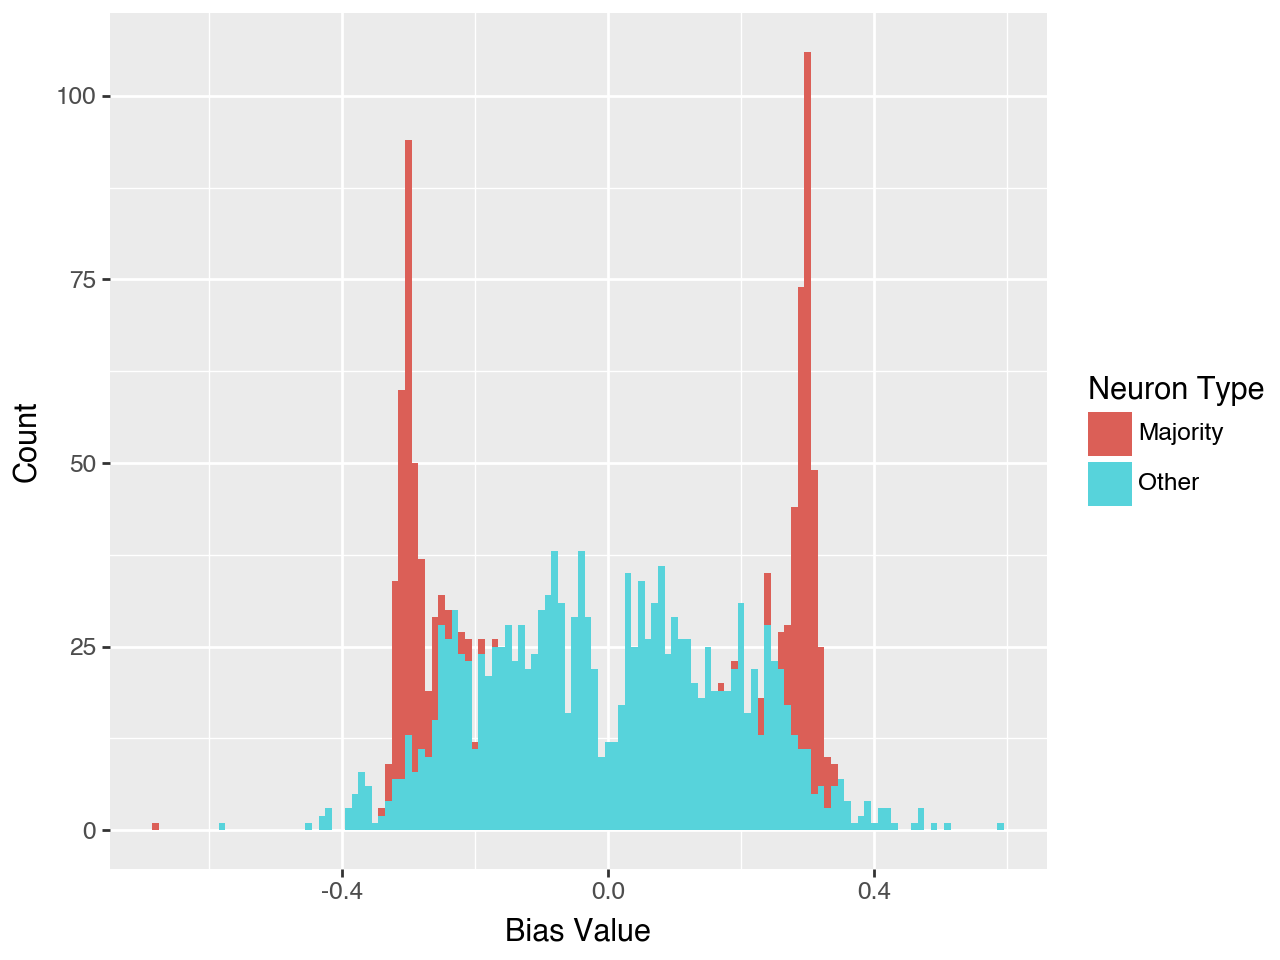

In [339]:
neuron_var_df = neuron_var_df.with_columns(
    bias_val = model.linear.bias.detach().numpy(),
    neuron_type = pl.when(pl.col('neuron_var').lt(0.0001)).then(pl.lit('Majority')).otherwise(pl.lit('Other'))
)

ggplot(neuron_var_df, aes(x='bias_val', fill = 'neuron_type')) + geom_histogram(binwidth = 0.01) + labs(x= 'Bias Value', y = 'Count', fill='Neuron Type')

I haven't been able to derive yet an analytical expression for majority neurons with a bias, but I think a similar approach I lay out at the end here will work. But it does look like we can use biases with majority neurons to separate out even/odd elements when $n$ is odd.

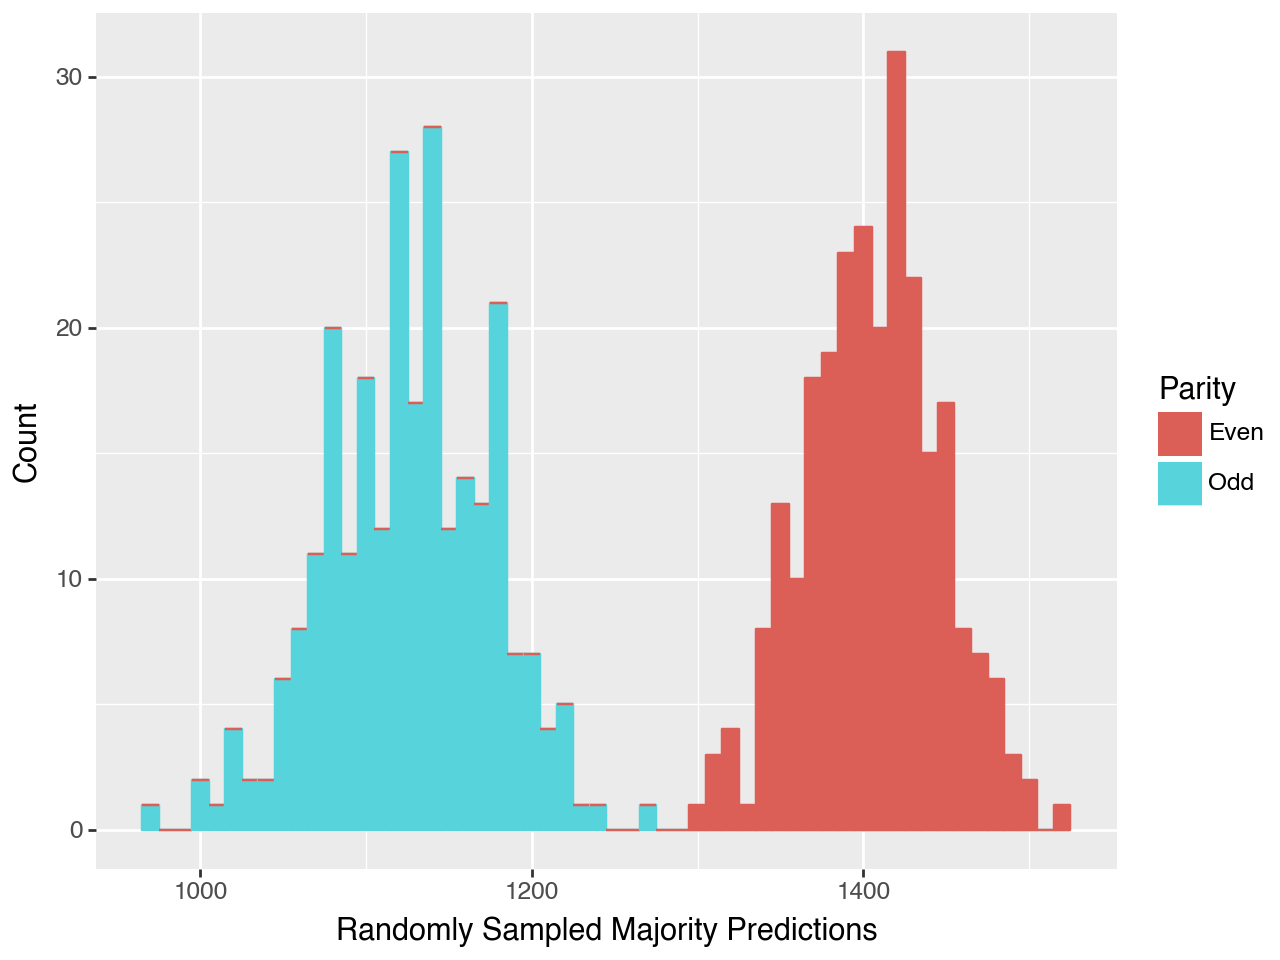

In [348]:
# n is odd now
n = 9
num_neurons = 2 ** (n + 1) # Twice as many as elements of small_cube
small_cube = torch.from_numpy(generate_all_binary_arrays(n))

W_rand = rademacher((num_neurons, n))
biases = W_rand.prod(dim=1, keepdims=True) # use the parity of W as the bias now

# Use the parity as the bias and just sum all the different neurons together
rand_predictions = relu(W_rand @ small_cube.T + biases).sum(dim=0)

data = {
    'preds': rand_predictions.detach().numpy(),
    'parity': [parity(int(x.item())) for x in small_cube.prod(dim=1)],
}


df = pl.DataFrame(data)

(
    ggplot(df, aes(x='preds', color='parity', fill='parity'))
    + geom_histogram(binwidth=10)
    + labs(x = 'Randomly Sampled Majority Predictions', y = 'Count', fill='Parity', color='Parity')
)

And that is as far as I've gotten! This is only a portion of the network -- there are plenty of other neurons besides these "majority" ones, but I like that this seems to be part of what the model is doing. On the other hand, this clearly doesn't converge fast enough for the model to be as good as it is with _just_ these "majority" neurons.

# Too Much Mathematical Detail

Proving this is a little more involved and to be honest this is still quite messy.

First, we need to justify quickly why the analysis of the "majority" neurons works despite them all having different sign patterns.

### Sign Flips Induce a Permutation Action on the Whole Boolean Cube

Let $f_w: \{ -1, 1 \}^n \rightarrow \mathbb{R}$ be an unbiased ReLU neuron with weight vector $w$:

$$ f_w(x) = \max (\langle w, x \rangle, 0)$$

The automorphism group of the boolean cube is the [hyperoctahedral group](https://en.wikipedia.org/wiki/Hyperoctahedral_group) $B_n$ of permutations and sign-flips. Notice that any $\sigma$ in the hyperoctahedral group acts on the weight vector $w$ of a ReLU neuron (or linear threshold function) by permuting and flipping the signs of its elements:
$$ f_{\sigma(w)}(x) = \max (\langle \sigma (w), x \rangle, 0)$$

But this is the same as applying $\sigma^{-1}$ to $x$, so:

$$ f_{\sigma(w)}(x) = f_w (\sigma^{-1}(x)) $$

But $\sigma^{-1}(x)$ is an automorphism of the boolean cube, so $f_{\sigma(w)}$ and $f_w$ are really the "same function" up to an automorphism / permutation action of the whole cube.

In particular this means that: every LTF and ReLU neuron has a "canonical" form where all of the elements are positive and in decreasing order of magnitude.

These automorphisms also play nicely with the Fourier transform. For any subset $S \subseteq \{-1, 1 \}^n$, the Fourier transform of $\hat{f}_{\sigma(w)}(S)  = \hat{f}_w (\sigma^{-1}(S))$.

This is fundamentally what justifies analyzing just the "majority" neuron where all of the weights are $1$ and what motivates the inclusion of the parity of $w$ in the formula.


### The Fourier Coefficients of a Majority Neuron

On the boolean cube a ReLU neuron is closely related to a linear threshold function (LTF), which is a well studied class of boolean functions. An LTF is a boolean function $\text{sgn}(\langle w, x \rangle + b)$ whereas a ReLU neuron is $\max (\langle w, x \rangle + b, 0)$. Let's consider only unbiased function with $b=0$. We denote a ReLU neuron with weight vector $w$ as $f_w$ and the LTF with $L_w$ then we get:

$$ f_w(x) = \langle w, x \rangle/2 + L_w(x)\langle w, x \rangle/2$$

Our first step is to get the coefficients of the LTF. The Fourier coefficients of a _majority_ linear threshold function are known analytically, and you can check section 5.3 of [_The Analysis of Boolean Functions_](https://arxiv.org/pdf/2105.10386) by Ryan O'Donnell for a derivation. Unfortunately this formula only works when $n$ is odd. When $n$ is even you need to figure out how to treat ties. I think this _should_ be pretty tractable if we consider the not-quite-LTF with a codomain $\{-1, 0, 1 \}$, leaving the ties as 0s, which should minimally affect the Fourier transform.

I think the basic proof strategy O'Donnell takes should work to get analytical values for even-$n$ majority. 

Let's denote our modified majority as $M_n$. The discrete / boolean derivative $\text{D} M_n$ is the $0$-$\frac{1}{2}$ indicator of when the restriction to $m = n - 1$ bits has _either_ $\frac{m+1}{2}$ -1s or $\frac{m-1}{2}$ -1s. It's $\frac{1}{2}$ because the difference is always between $\pm1$ and $0$. Let's just continue as if it were the 0-1 indicator for a bit.

Then the noise operator for $\text{D} M_n$ is

$$T_\rho(\text{D} M_n)(1, 1, \cdots, 1) = \mathbb{P}(x \; \text{has} \; \frac{m+1}{2} \; 1\text{s}) + \mathbb{P}(x \; \text{has} \; \frac{m-1}{2} \; 1\text{s})$$

Where each coordinate of $x$ is $1$ with probability $\frac{1}{2} + \frac{\rho}{2}$. So using the formula for the binomial distribution we get:

$$ T_\rho(\text{D} M_n)(1, 1, \cdots, 1) = \comb{m}{\frac{m+1}{2}} (1/2 + \rho/2)^{\frac{m+1}{2}}(1/2 - \rho/2)^{\frac{m-1}{2}} +\begin{pmatrix} m \\ \frac{m-1}{2} \end{pmatrix}(1/2 + \rho/2)^{\frac{m-1}{2}}(1/2 - \rho/2)^{\frac{m+1}{2}}$$

But this simplifies nicely. $$ \begin{pmatrix} m \\ \frac{m+1}{2} \end{pmatrix} = \begin{pmatrix} m \\ \frac{m-1}{2} \end{pmatrix}$$ when $m$ is odd because choices of $(m+1)/2$ elements are one-to-one with choices of $(m-1)/2$ elements -- for any set of  $(m+1)/2$ there are exactly $(m-1)/2$ remaining elements you didn't pick.

Then we can bring out each inner term up to the power of $(m-1)/2$. And since $(m+1)/2 - (m-1)/2 = 1$, we end up with:

$$ \frac{1}{2^m}\begin{pmatrix} m \\ \frac{m-1}{2} \end{pmatrix} (1 - \rho^2)^{\frac{m-1}{2}} $$

But from the Fourier formula for $T_\rho$ we know that:

$$ T_\rho(\text{D} M_n)(1, 1, \cdots, 1) = \sum_{i=0}^m \begin{pmatrix} m \\ i\end{pmatrix}\hat{D M}_n([i])\rho^i  $$

So we can just index into $(1-\rho^2)^{\frac{m-1}{2}}$ and divide by $\begin{pmatrix} m \\ i\end{pmatrix}$ to get each term. Putting it all together, for a degree $k$ term of $\hat{D M}_n$

$$ 2^{-m} \cdot  \begin{pmatrix} m \\ \frac{m-1}{2} \end{pmatrix} \cdot (-1)^{k/2} \cdot \begin{pmatrix} \frac{m}{2} \\ \frac{k}{2} \end{pmatrix} / \begin{pmatrix} m \\ k \end{pmatrix} $$ 

But a degree $k$ terms for $\hat{D M}_n$ maps to a degree $k+1$ term for $\hat{M}_n$. So all in all in Python it looks like:

In [349]:
#| echo: true
from math import comb

def analytic_coefficients(n, k):
    if n % 2 != 0:
        raise ValueError(f'Only valid for even n, not {n}')
    m = n - 1
    k = k - 1
    if k % 2 == 1 or k < 0:
        return 0.
    normalization = (2 ** (-m))
    binomial_pmf = comb(m, int((m - 1)/2)) # from combinatorial calculation of noise operator
    binomial_theorem = (-1) ** (k / 2) * comb(int((m-1)/2), int(k/2)) # from indexing into (1 - rho**2)**((m-1)/2)
    final_norm = comb(m, k) # From the Fourier calculation of the noise operator
    
    return normalization * binomial_pmf * binomial_theorem / final_norm

Ok, that was all a lot of work to get the the Fourier coefficients for the **LTF** of majority for even $n$. But we want it for a ReLU function. Luckily we just did all of the work.

Recall that our ReLU majority neuron is $\langle \mathbf{1}, x \rangle / 2 + M_n(x)\langle \mathbf{1}, x \rangle / 2$

The Fourier coefficients for $\langle \mathbf{1}, x \rangle / 2$ are just $1/2$ on the degree 1 terms and zero elsewhere. Reversing the usual convolution theorem the Fourier transform of $M_n(x)\langle \mathbf{1}, x \rangle / 2$ is given by the convolution of $\hat{M}_n$ and the degree 1 terms. So we increase the degree again and multiply $\hat{M}_n$ by $n/2$. And that's it!